In [3]:
#!/usr/bin/env python3
"""Visualization script for Go1 with height scanner."""
import os
# Tell XLA to use Triton GEMM
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
os.environ['MUJOCO_GL'] = 'egl'

import jax
import jax.numpy as jp
import numpy as np
import mujoco
import cv2
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPyimage, display
from environments.custom_env import Joystick, default_config
from io import BytesIO

AttributeError: type object 'mujoco._enums.mjtDisableBit' has no attribute 'mjDSBL_PASSIVE'

Loading the possible environments

In [1]:
# Get paths
from config import ProjectPaths
env_paths = {
    'custom': ProjectPaths.CUSTOM_ENV_XML, # Maybe should be named default
    'custom_debug': ProjectPaths.CUSTOM_ENV_DEBUG_XML,
    'stairs': ProjectPaths.STAIRS_ENV_XML
}

print("Available Environments:")
print("=" * 35)
for key in env_paths:
    print(f"'{key}'")



Available Environments:
'custom'
'custom_debug'
'stairs'


In [2]:

# Set up visualization options
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True   # Show visual geoms
scene_option.geomgroup[3] = False  # Hide collision geoms
scene_option.geomgroup[5] = True   # Show sites (including height scanner visualization)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True  # Show contact points
scene_option.flags[mujoco.mjtVisFlag.mjVIS_RANGEFINDER] = True
print("Creating Visualization...")

# We will no longer use the registry, but directly load our custom XML and model.
# We will load the "debug" version here, which adds an additional wall *under* the robot
# We add this to understand that changing walls correctly affects collision + raycasting.
xml_path = env_paths['custom'] # 'custom_env.xml' # 'custom_env_debug_wall.xml' #TODO: set this to the environment you want to train in
env = Joystick(xml_path=xml_path, config=default_config())

# NOTE: For this test, we manually set init_q z position high to avoid collisions with walls 
# env._init_q = env._init_q.at[2].set(1.0)

# JIT compile the functions for speed
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_terrain_height = jax.jit(env._get_torso_terrain_height)


NameError: name 'mujoco' is not defined

In [ ]:
# Imports
from typing import Any, Tuple
from brax.training import types
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.types import Params
import flax
import jax
import jax.numpy as jnp
from brax.training.agents.ppo.losses import compute_gae

# Helper Struct for policy and value params
@flax.struct.dataclass
class PPONetworkParams:
  """Contains training state for the learner."""

  policy: Params
  value: Params

# PPO loss function to be implemented
def compute_custom_ppo_loss(
    params: PPONetworkParams,
    normalizer_params: Any,
    data: types.Transition,
    rng: jnp.ndarray,
    ppo_network: ppo_networks.PPONetworks,
    entropy_cost: float = 1e-4,
    discounting: float = 0.9,
    reward_scaling: float = 1.0,
    gae_lambda: float = 0.95,
    clipping_epsilon: float = 0.3,
    normalize_advantage: bool = True,
) -> Tuple[jnp.ndarray, types.Metrics]:
  """Computes PPO loss.

  Args:
    params: Network parameters,
    normalizer_params: Parameters of the normalizer.
    data: Transition that with leading dimension [B, T]. extra fields required
      are ['state_extras']['truncation'] ['policy_extras']['raw_action']
      ['policy_extras']['log_prob']
    rng: Random key
    ppo_network: PPO networks.
    entropy_cost: entropy cost.
    discounting: discounting,
    reward_scaling: reward multiplier.
    gae_lambda: General advantage estimation lambda.
    clipping_epsilon: Policy loss clipping epsilon
    normalize_advantage: whether to normalize advantage estimate

  Returns:
    A tuple (loss, metrics)
  """
  parametric_action_distribution = ppo_network.parametric_action_distribution
  policy_apply = ppo_network.policy_network.apply
  value_apply = ppo_network.value_network.apply

  # Put the time dimension first.
  data = jax.tree_util.tree_map(lambda x: jnp.swapaxes(x, 0, 1), data)
  policy_logits = policy_apply(
      normalizer_params, params.policy, data.observation
  )

  baseline = value_apply(normalizer_params, params.value, data.observation)
  terminal_obs = jax.tree_util.tree_map(lambda x: x[-1], data.next_observation)
  bootstrap_value = value_apply(normalizer_params, params.value, terminal_obs)

  rewards = data.reward * reward_scaling
  truncation = data.extras['state_extras']['truncation']
  termination = (1 - data.discount) * (1 - truncation)

  target_action_log_probs = parametric_action_distribution.log_prob(
      policy_logits, data.extras['policy_extras']['raw_action']
  )
  behaviour_action_log_probs = data.extras['policy_extras']['log_prob']

  vs, advantages = compute_gae(
      truncation=truncation,
      termination=termination,
      rewards=rewards,
      values=baseline,
      bootstrap_value=bootstrap_value,
      lambda_=gae_lambda,
      discount=discounting,
  )
  if normalize_advantage:
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
  
  # TODO: Compute probability ratio between new and old policy
  # Hint: Use jnp.exp() and compute the difference between log probabilities
  rho_s = jnp.exp(target_action_log_probs - behaviour_action_log_probs)
  
  # TODO: Implement the PPO clipped surrogate objective
  # Hint: Compare unclipped (rho_s * advantages) vs clipped version
  # Use jnp.clip() with clipping_epsilon parameter
  surrogate_loss1 = rho_s * advantages
  surrogate_loss2 = jnp.clip(rho_s, 1 - clipping_epsilon, 1 + clipping_epsilon) * advantages

  # TODO: PPO policy loss is the negative mean of the minimum of both surrogates
  policy_loss = -jnp.mean(jnp.minimum(surrogate_loss1, surrogate_loss2))

  # TODO: Implement value function loss
  # Hint: Mean squared error between vs (targets) and baseline (predictions)
  # Scale by 0.5 * 0.5 as in the original implementation
  v_error =(vs - baseline)**2
  v_loss = 0.25*jnp.mean(v_error) # 0.5 seems to be faster

  # TODO: Implement entropy loss for exploration
  # Hint: Use parametric_action_distribution.entropy() and multiply by entropy_cost
  # Make it negative since we want to maximize entropy (minimize negative entropy)
  entropy = parametric_action_distribution.entropy(policy_logits, rng)
  entropy_loss = -entropy_cost*jnp.mean(entropy)

  # TODO: Combine all loss components
  total_loss = policy_loss + v_loss + entropy_loss
  
  return total_loss, {
      'total_loss': total_loss,
      'policy_loss': policy_loss,
      'v_loss': v_loss,
      'entropy_loss': entropy_loss,
  }

In [ ]:
import os
import subprocess
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import functools
from brax.training.agents.ppo import networks as ppo_networks
from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.config import locomotion_params
from brax.training.agents.ppo import losses as ppo_losses
from IPython.display import HTML, clear_output
import mujoco
import jax
import jax.numpy as jp
import cv2
import training.custom_ppo_train as custom_ppo_train
from utils import render_video_during_training, evaluate_policy
import mediapy as media



env_cfg = default_config()

x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

# Store the current policy for video rendering
current_policy = None

def progress(num_steps, metrics):
    clear_output(wait=True)

    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    y_dataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, ppo_training_params["num_timesteps"] * 1.25])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")
    plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")
    
    # Save the plot to a file instead of displaying it
    display(plt.gcf())

    # Render video if we have a current policy
    if current_policy is not None:
        render_video_during_training(current_policy, num_steps, jit_step, jit_reset, env_cfg, env)

ppo_params = locomotion_params.brax_ppo_config('Go1JoystickRoughTerrain')
ppo_training_params = dict(ppo_params)

ppo_training_params["num_evals"] = 10 # Reduce for final training for less feedback. (originally 25)
ppo_training_params["num_timesteps"] = 150000000  # Total number of training steps (originally 200000000)
 
network_factory = ppo_networks.make_ppo_networks

if "network_factory" in ppo_params:
    del ppo_training_params["network_factory"]
    network_factory = functools.partial(
        ppo_networks.make_ppo_networks,
        **ppo_params.network_factory
    )
print(ppo_training_params)


# Create a policy parameters callback to capture the current policy
def policy_params_callback(_, make_policy_fn, params):
    # Update the current policy for video rendering
    global current_policy
    current_policy = make_policy_fn(params, deterministic=True)
    
train_fn = functools.partial(
        custom_ppo_train.train,
        **ppo_training_params,
        network_factory=network_factory,
        # randomization_fn=randomizer,
        progress_fn=progress,
        policy_params_fn=policy_params_callback,
)

{'action_repeat': 1, 'batch_size': 256, 'discounting': 0.97, 'entropy_cost': 0.01, 'episode_length': 1000, 'learning_rate': 0.0003, 'max_grad_norm': 1.0, 'normalize_observations': True, 'num_envs': 8192, 'num_evals': 10, 'num_minibatches': 32, 'num_resets_per_eval': 1, 'num_timesteps': 150000000, 'num_updates_per_batch': 4, 'reward_scaling': 1.0, 'unroll_length': 20}


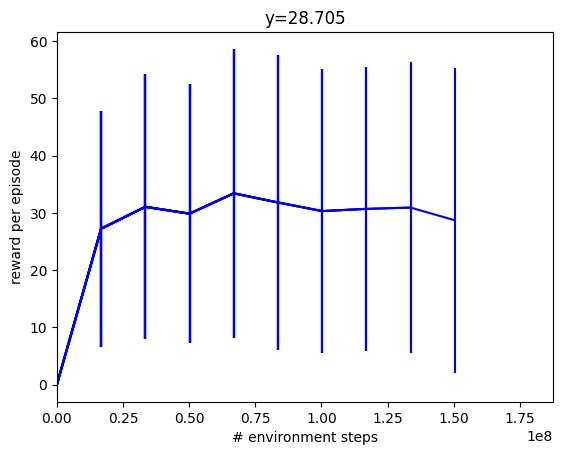

100%|██████████| 80/80 [00:15<00:00,  5.01it/s]


Training completed.


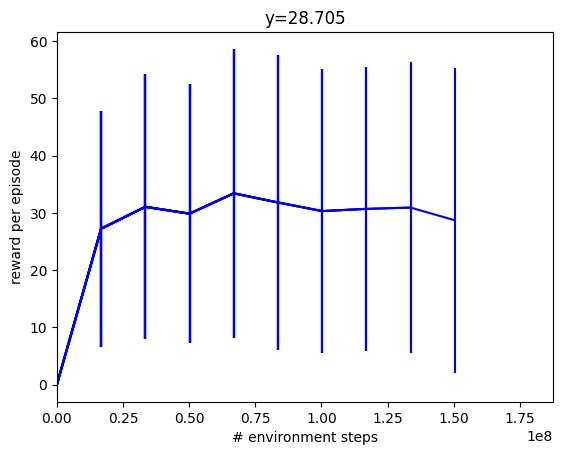

In [ ]:
print("Starting training...")
make_policy, params, _ = train_fn(environment=env,
                                  eval_env=env,
                                  wrap_env_fn=wrapper.wrap_for_brax_training,
                                  compute_custom_ppo_loss_fn=compute_custom_ppo_loss
                                 )
print("Training completed.")

In [ ]:
# Save parameters from training
file_name = "name_of_param_file.npy"

# Save
np.save(os.path.join(ProjectPaths.PARAMETERS, file_name), params, allow_pickle=True)
print(f"PPO params saved to {file_name}")

PPO params saved to params_with_height_and_knee.npy


In [7]:
# Optional load params and recreate network
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import losses as ppo_losses
from brax.training.acme import running_statistics

seed = 42
num_envs = ()
key = jax.random.PRNGKey(seed)
key, key_env, eval_key, key_policy, key_value = jax.random.split(key, 5)
key_envs = jax.random.split(key_env, num_envs)
env_state = jit_reset(key_envs)


# Needs to match training
obs_shape = (96,)
action_size = env.action_size

# Observation normalisation
params = np.load(file_name, allow_pickle=True)
normalizer_params = params[0]  
normalize = running_statistics.normalize

# Setup
ppo_params = locomotion_params.brax_ppo_config('Go1JoystickRoughTerrain')
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
    network_factory = functools.partial(
        ppo_networks.make_ppo_networks,
        **ppo_params.network_factory
    )

ppo_network = network_factory(
    obs_shape, action_size, preprocess_observations_fn=normalize
)

init_params = ppo_losses.PPONetworkParams(
    policy=ppo_network.policy_network.init(key_policy),
    value=ppo_network.value_network.init(key_value),
)

# Create policy function
make_policy = ppo_networks.make_inference_fn(ppo_network)


In [ ]:

env_cfg.pert_config.enable = True
env_cfg.pert_config.velocity_kick = [3.0, 6.0]
env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
env_cfg.command_config.a = [1.5, 0.8, 2*jp.pi]
xml_path = env_paths['custom'] # 'custom_env_debug_wall.xml'
eval_env = Joystick(xml_path=xml_path, config=default_config())
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_policy(params, deterministic=True))

evaluate_policy(
    eval_env,
    jit_inference_fn,
    jit_step,
    jit_reset,
    env_cfg,
    eval_env,
    velocity_kick_range,
    kick_duration_range,
)

100%|██████████| 500/500 [01:58<00:00,  4.21it/s]


100%|██████████| 500/500 [01:44<00:00,  4.80it/s]


100%|██████████| 500/500 [01:38<00:00,  5.06it/s]
